In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, TimeSeriesSplit

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Layer,
    Dense,
    Input,
    Concatenate,
    GlobalAveragePooling1D,
    Dropout,
    LayerNormalization,
    Conv1D
)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, mean_absolute_percentage_error


## Load Data

In [3]:
data_path = '/content/data.csv'
df = pd.read_csv(data_path)
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df.shape

(738, 9)

## Data Visualization

In [4]:
def draw_plot(x,y,title,x_label,y_label):
  fig, ax = plt.subplots()
  ax.plot(x,y)
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  ax.set_title(title)
  ax.xaxis.set_major_locator(mdates.MonthLocator()) # The main markers on the x-axis will represent the months.
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # Dates will be displayed in year-month format, for example 2022-01.
  plt.xticks(rotation=45)
  plt.show()

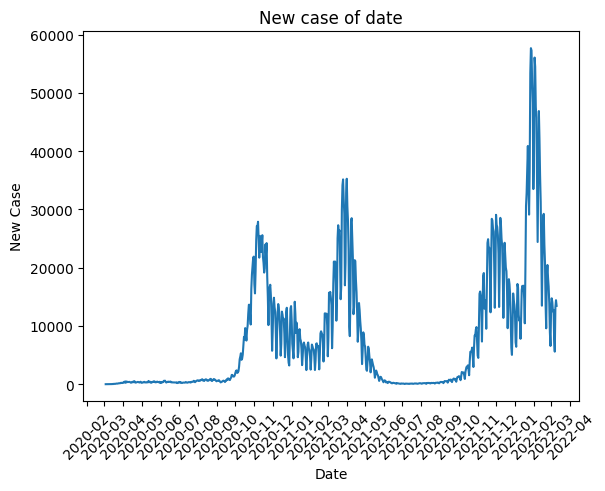

In [5]:
draw_plot(x=df['date'], y=df['new_cases'],title='New case of date',x_label='Date',y_label='New Case')

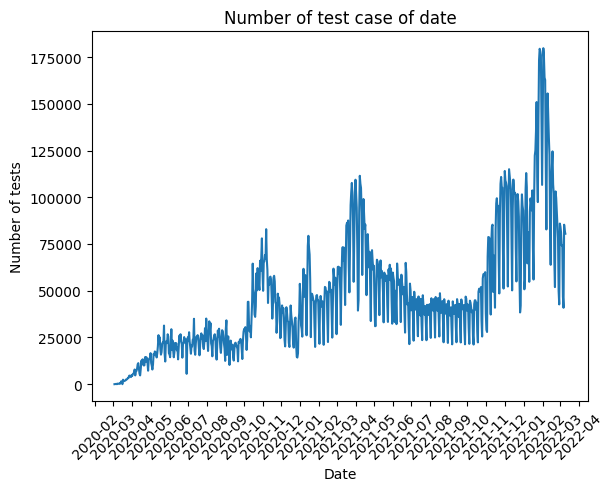

In [6]:
draw_plot(x=df['date'], y=df['tests'],title='Number of test case of date',x_label='Date',y_label='Number of tests')

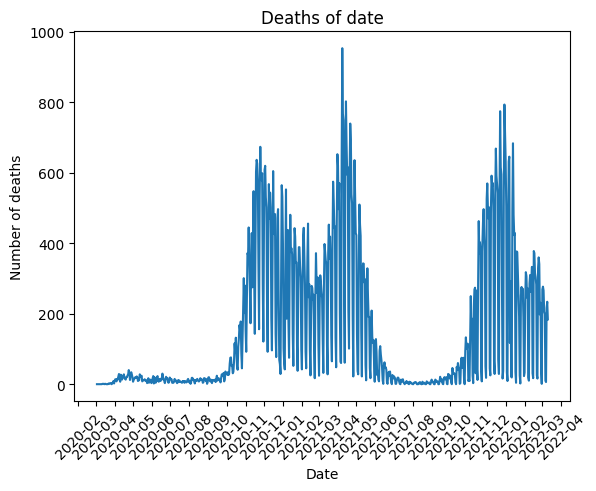

In [7]:
draw_plot(x=df['date'], y=df['new_deaths'],title='Deaths of date',x_label='Date',y_label='Number of deaths')

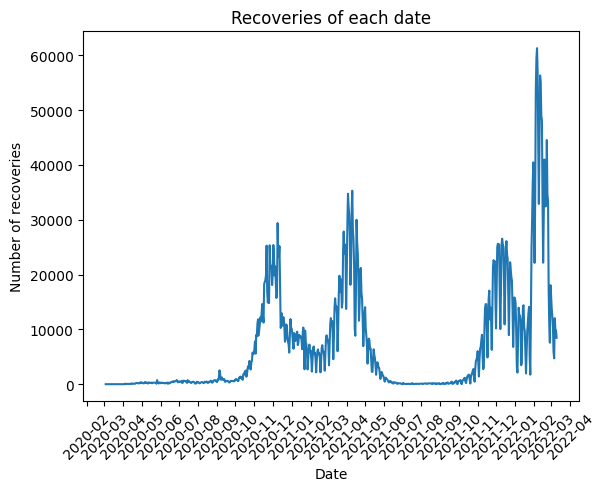

In [8]:
draw_plot(x=df['date'], y=df['new_recoveries'],title='Recoveries of each date',x_label='Date',y_label='Number of recoveries')

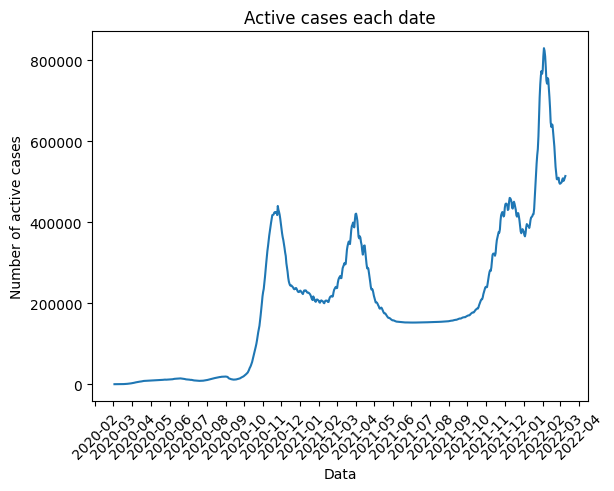

In [9]:
draw_plot(x=df['date'], y=df['active_cases'],title='Active cases each date',x_label='Data',y_label='Number of active cases')

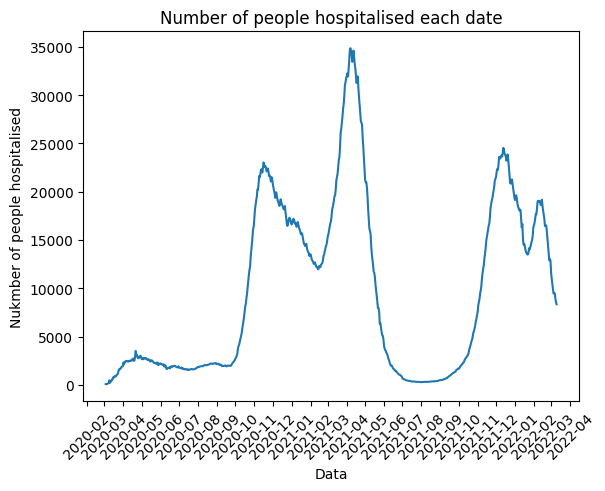

In [10]:
draw_plot(x=df['date'], y=df['people_hospitalised'],title='Number of people hospitalised each date',x_label='Data',y_label='Nukmber of people hospitalised')

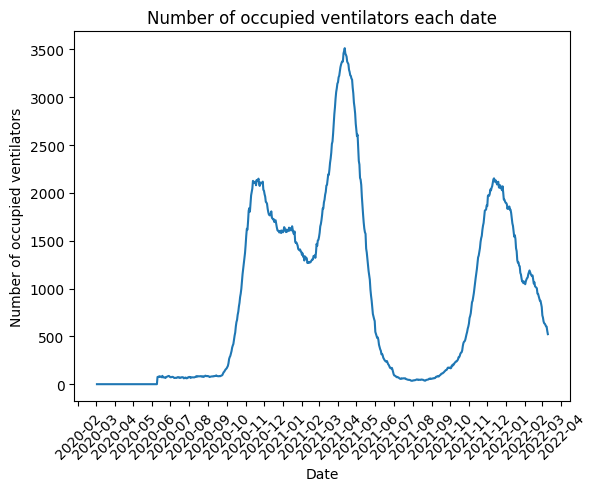

In [11]:
draw_plot(x=df['date'], y=df['occupied_ventilators'],title='Number of occupied ventilators each date',x_label='Date',y_label='Number of occupied ventilators')

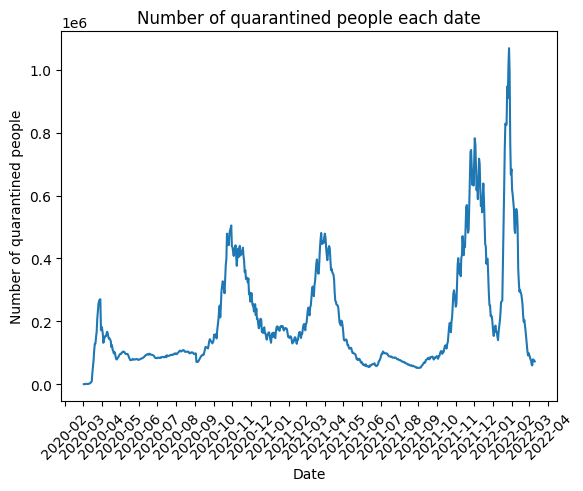

In [12]:
draw_plot(x=df['date'], y=df['quarantined_people'],title='Number of quarantined people each date',x_label='Date',y_label='Number of quarantined people')

## Prepare Data

In [13]:
df = df.drop(columns=['date'])

In [14]:
df = df.drop(columns=['new_deaths', 'people_hospitalised', 'occupied_ventilators', 'quarantined_people'])
columns = df.columns
columns

Index(['tests', 'new_recoveries', 'active_cases', 'new_cases'], dtype='object')

In [15]:
df['tests'] = df['tests'].replace(to_replace=0, method='bfill')

<ipython-input-15-b23f7d715de4>:1: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['tests'] = df['tests'].replace(to_replace=0, method='bfill')


In [16]:
scaler = MinMaxScaler()
df[columns] = scaler.fit_transform(df[columns])
df.head()

,tests,new_recoveries,active_cases,new_cases
0,0.000000,0.0,0.000000,0.000000
1,0.000000,0.0,0.000001,0.000017
2,0.000373,0.0,0.000001,0.000000
3,0.000857,0.0,0.000006,0.000069
4,0.001524,0.0,0.000007,0.000017


## Create model

In [17]:
class Time2Vector(Layer):
  '''Embedding Layer representing time as a vector'''
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len # length of a time sequence in each input

  def build(self, input_shape):
    '''Initializes weights for periodic and non-periodic features'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculates periodic and non-periodic features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1)
    time_linear = self.weights_linear * x + self.bias_linear # non-periodic feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension

    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic) # periodic feature
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension
    return tf.concat([time_linear, time_periodic], axis=-1)

  def get_config(self):
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

In [18]:
class SingleAttention(Layer):
  '''Single attention layer'''
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    ''' Initialized dense networks for each of inputs'''
    self.query = Dense(self.d_k,
                       input_shape=input_shape,
                       kernel_initializer='glorot_uniform',
                       bias_initializer='glorot_uniform')

    self.key = Dense(self.d_k,
                     input_shape=input_shape,
                     kernel_initializer='glorot_uniform',
                     bias_initializer='glorot_uniform')

    self.value = Dense(self.d_v,
                       input_shape=input_shape,
                       kernel_initializer='glorot_uniform',
                       bias_initializer='glorot_uniform')

  def call(self, inputs):
    ''' Calculated attention output '''
    q = self.query(inputs[0]) # represents positions of interest in the sequence
    k = self.key(inputs[1]) # represents information about different positions

    attn_weights = tf.matmul(q, k, transpose_b=True) # dot product measures similarity between query and key
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights) # scaling the dot product (to stabilize gradients)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1) # normalize attention weights to 1 using softmax

    v = self.value(inputs[2]) # represents features
    attn_out = tf.matmul(attn_weights, v) # emphasizes the value vectors that are most relevant to each query position
    return attn_out # return relevant information form the value vector

In [19]:
class MultiAttention(Layer):
  '''Multi attention layer'''
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    ''' Creates n_heads SingleAttention layers and a Dense layer'''
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))

    self.linear = Dense(input_shape[0][-1],
                        input_shape=input_shape,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    ''' Concatenates and lineary transforms output from each SingleAttention layer'''
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear

In [20]:
class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    # self-attention part
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    # feed forward part
    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1)
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

  def call(self, inputs):
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer

  def get_config(self):
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config

In [21]:
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

seq_len = 28
num_features = 4

In [22]:
def create_model():
    '''Initialize time embedding and transformer layers'''
    time_embedding = Time2Vector(seq_len)
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

    '''Construct model'''
    in_seq = Input(shape=(seq_len, num_features))
    x = time_embedding(in_seq)
    x = Concatenate(axis=-1)([in_seq, x])
    x = attn_layer1((x, x, x))
    x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))
    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    out = Dense(1, activation='linear')(x)

    model = Model(inputs=in_seq, outputs=out)
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
    return model

def calculate_index_of_agreement(y_true, y_pred):
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum((np.abs(y_pred - np.mean(y_true)) + np.abs(y_true - np.mean(y_true))) ** 2)
    index_of_agreement = 1 - (numerator / denominator)
    return index_of_agreement

# Define helper functions for evaluation
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    index_of_agreement = calculate_index_of_agreement(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, mae, r2, index_of_agreement, mape

def print_evaluation_results_extended(mse_scores, mae_scores, r2_scores, index_of_agreement_scores, mape_scores):
    print('---------------------------')
    print('Average MSE:', np.mean(mse_scores))
    print('Average MAE:', np.mean(mae_scores))
    print('Average R^2:', np.mean(r2_scores))
    print(f"Mean Index of Agreement: {np.mean(index_of_agreement_scores)}")
    print(f"MAPE: {np.mean(mape_scores)}")
    print('---------------------------')

## Model evaluation

In [23]:
n_splits = 4

batch_size = 16
num_epochs = 50

#### Using KFold

In [23]:
mse_scores = []
mae_scores = []
r2_scores = []
index_of_agreement_scores = []
mape_scores = []

kfold = KFold(n_splits=n_splits)

for train_index, test_index in kfold.split(df):

    # Split data into train and test
    train_data = df.iloc[train_index].values
    test_data = df.iloc[test_index].values

    # Arrange train data into X_train and y_train
    X_train, y_train = [], []
    for i in range(seq_len, len(train_data)):
        X_train.append(train_data[i-seq_len:i])
        y_train.append(train_data[:, num_features-1][i])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Arrange test data into X_test and y_test
    X_test, y_test = [], []
    for i in range(seq_len, len(test_data)):
        X_test.append(test_data[i-seq_len:i])
        y_test.append(test_data[:, num_features-1][i])
    X_test, y_test = np.array(X_test), np.array(y_test)

    # Build and train model
    model = create_model()
    model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=0)

    # Evaluate model
    y_pred = model.predict(X_test)
    mse, mae, r2, index_of_agreement, mape = evaluate_model(y_test, y_pred)
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    index_of_agreement_scores.append(index_of_agreement)
    mape_scores.append(mape)

    print(f"MSE: {mse}, MAE: {mae}, R^2: {r2}, Index of Agreement: {index_of_agreement}, Mean Absolute Percentage Error: {mape} ")

# Print evaluation results for the current split method
print("Split Method: KFold")
print_evaluation_results_extended(mse_scores, mae_scores, r2_scores, index_of_agreement_scores, mape_scores)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/layer_normalization.py:123: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
MSE: 0.0007137931635482912, MAE: 0.023156562378034515, R^2: -83.32787937091531, Index of Agreement: 0.1351704818700893, Mean Absolute Percentage Error: 3.8265950735131646 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/layer_normalization.py:123: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
MSE: 0.0025516919774278466, MAE: 0.042687036352240235, R^2: 0.7942977565747202, Index of Agreement: 0.4056476307559447, Mean Absolute Percentage Error: 0.337464382026213 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/layer_normalization.py:123: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/layer_normalization.py:123: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MSE: 0.0011936484925439543, MAE: 0.026641833955337726, R^2: 0.875900878092931, Index of Agreement: 0.2823911201317989, Mean Absolute Percentage Error: 6.869419832349197 
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
MSE: 0.01973388090914778, MAE: 0.0943379591954449, R^2: 0.5986894645585692, Index of Agreement: 0.3904884029204998, Mean Absolute Percentage Error: 0.3470653052642112 
Split Method: KFold
---------------------------
Average MSE: 0.006048253635666968
Average MAE: 0.04670584797026434
Average R^2: -20.26474781792227
Mean Index of Agreement: 0.30342440891958317
MAPE: 2.8451361482881965
---------------------------


#### Using TimeSeriesSplit

In [29]:
mse_scores = []
mae_scores = []
r2_scores = []
index_of_agreement_scores = []
mape_scores = []

tss = TimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in tss.split(df):

    # Split data into train and test
    train_data = df.iloc[train_index].values
    test_data = df.iloc[test_index].values

    # Arrange train data into X_train and y_train
    X_train, y_train = [], []
    for i in range(seq_len, len(train_data)):
        X_train.append(train_data[i-seq_len:i])
        y_train.append(train_data[:, num_features-1][i])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Arrange test data into X_test and y_test
    X_test, y_test = [], []
    for i in range(seq_len, len(test_data)):
        X_test.append(test_data[i-seq_len:i])
        y_test.append(test_data[:, num_features-1][i])
    X_test, y_test = np.array(X_test), np.array(y_test)

    # Build and train model
    model = create_model()
    model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=0)

    # Evaluate model
    y_pred = model.predict(X_test)
    mse, mae, r2, index_of_agreement, mape = evaluate_model(y_test, y_pred)
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    index_of_agreement_scores.append(index_of_agreement)
    mape_scores.append(mape)

    print(f"MSE: {mse}, MAE: {mae}, R^2: {r2}, Index of Agreement: {index_of_agreement}, Mean Absolute Percentage Error: {mape} ")

# Print evaluation results for the current split method
print("Split Method: TimeSeriesSplit")
print_evaluation_results_extended(mse_scores, mae_scores, r2_scores, index_of_agreement_scores, mape_scores)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/layer_normalization.py:123: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
MSE: 0.04696305040374921, MAE: 0.16174030287458216, R^2: -1.256818974575149, Index of Agreement: 0.45985078169192994, Mean Absolute Percentage Error: 0.8128338326123091 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/layer_normalization.py:123: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
MSE: 0.027482058573607512, MAE: 0.14271169921404428, R^2: -0.16488812606334435, Index of Agreement: 0.32888483172365635, Mean Absolute Percentage Error: 1.3572425625517408 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/layer_normalization.py:123: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
MSE: 0.00012866496924677148, MAE: 0.007719915006293456, R^2: -0.3280594032690938, Index of Agreement: 0.24200849075136477, Mean Absolute Percentage Error: 2.151560020268924 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/layer_normalization.py:123: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
MSE: 0.023678594012984354, MAE: 0.1005984581201116, R^2: 0.47746270106166777, Index of Agreement: 0.38411920680775824, Mean Absolute Percentage Error: 0.23595980263494926 
Split Method: TimeSeriesSplit
---------------------------
Average MSE: 0.024563091989896958
Average MAE: 0.10319259380375786
Average R^2: -0.31807595071147987
Mean Index of Agreement: 0.35371582774367727
MAPE: 1.1393990545169805
---------------------------


#### Using BlockingTimeSeriesSplit

In [24]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits, margin=0):
        self.n_splits = n_splits
        self.margin = margin

    def get_n_splits(self, X, y, groups):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + self.margin: stop]

In [25]:
mse_scores = []
mae_scores = []
r2_scores = []
index_of_agreement_scores = []
mape_scores = []

btss = BlockingTimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in btss.split(df):

    # Split data into train and test
    train_data = df.iloc[train_index].values
    test_data = df.iloc[test_index].values

    # Arrange train data into X_train and y_train
    X_train, y_train = [], []
    for i in range(seq_len, len(train_data)):
        X_train.append(train_data[i-seq_len:i])
        y_train.append(train_data[:, num_features-1][i])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Arrange test data into X_test and y_test
    X_test, y_test = [], []
    for i in range(seq_len, len(test_data)):
        X_test.append(test_data[i-seq_len:i])
        y_test.append(test_data[:, num_features-1][i])
    X_test, y_test = np.array(X_test), np.array(y_test)

    # Build and train model
    model = create_model()
    model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=0)

    # Evaluate model
    y_pred = model.predict(X_test)
    mse, mae, r2, index_of_agreement, mape = evaluate_model(y_test, y_pred)
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    index_of_agreement_scores.append(index_of_agreement)
    mape_scores.append(mape)

    print(f"MSE: {mse}, MAE: {mae}, R^2: {r2}, Index of Agreement: {index_of_agreement}, Mean Absolute Percentage Error: {mape} ")

# Print evaluation results for the current split method
print("Split Method: TimeSeriesSplit")
print_evaluation_results_extended(mse_scores, mae_scores, r2_scores, index_of_agreement_scores, mape_scores)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/layer_normalization.py:123: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
MSE: 4.3441897314489754e-05, MAE: 0.006257988661143641, R^2: -9.149346896910274, Index of Agreement: 0.34798995665806565, Mean Absolute Percentage Error: 0.507946291118689 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/layer_normalization.py:123: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
MSE: 0.01513549767313915, MAE: 0.11621265227427378, R^2: -3.096794730376981, Index of Agreement: 0.38252262586385355, Mean Absolute Percentage Error: 0.5594848955885644 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/layer_normalization.py:123: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
MSE: 4.529683664797598e-05, MAE: 0.006591793876704521, R^2: -23.71423369389597, Index of Agreement: 0.2463132536070488, Mean Absolute Percentage Error: 1.2669247574228963 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/layer_normalization.py:123: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
MSE: 0.004867561202062321, MAE: 0.06275506872196188, R^2: -0.5021029740530756, Index of Agreement: 0.4680309870273619, Mean Absolute Percentage Error: 0.30892396958139506 
Split Method: TimeSeriesSplit
---------------------------
Average MSE: 0.005022949402290984
Average MAE: 0.04795437588352096
Average R^2: -9.115619573809074
Mean Index of Agreement: 0.3612142057890825
MAPE: 0.6608199784278862
---------------------------


## Final Model Training

In [24]:
#Split df into df_train and df_test

split_index_1 = sorted(df.index.values)[-int(0.3*len(df))]
split_index_2 = sorted(df.index.values)[-int(0.2*len(df))]

df_train = df[(df.index < split_index_1)] # 70% of data
df_val = df[(df.index >=split_index_1) & (df.index < split_index_2)] # 10% of data
df_test = df[(df.index >= split_index_2)] # 20% of data

train_data = df_train.values
val_data = df_val.values
test_data = df_test.values

print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (517, 4)
Validation data shape: (74, 4)
Test data shape: (147, 4)


In [25]:
# Arrange train data into X_train and y_train
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i])
  y_train.append(train_data[:, num_features-1][i])
X_train, y_train = np.array(X_train), np.array(y_train)

# Arrange validation data into X_val and y_val
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
  X_val.append(val_data[i-seq_len:i])
  y_val.append(val_data[:, num_features-1][i])
X_val, y_val = np.array(X_val), np.array(y_val)

# Arrange test data into X_test and y_test
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, num_features-1][i])
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(489, 28, 4) (489,)
(46, 28, 4) (46,)
(119, 28, 4) (119,)


In [26]:
# Train the final model on the entire training set
final_model = create_model()
final_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/layer_normalization.py:123: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 4)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time2_vector              │ (None, 28, 2)          │            112 │ input_layer[0][0]      │
│ (Time2Vector)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 28, 6)          │              0 │ input_layer[0][0],     │
│                           │                        │                │ time2_vector[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder       │ (None, 28, 6)          │         86,308 │ concatenate[0][0],     │
│ (TransformerEncoder)      │                        │                │ concatenate[0][0],     │
│                           │                        │                │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_1     │ (None, 28, 6)          │         86,308 │ transformer_encoder[0… │
│ (TransformerEncoder)      │                        │                │ transformer_encoder[0… │
│                           │                        │                │ transformer_encoder[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_2     │ (None, 28, 6)          │         86,308 │ transformer_encoder_1… │
│ (TransformerEncoder)      │                        │                │ transformer_encoder_1… │
│                           │                        │                │ transformer_encoder_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 28)             │              0 │ transformer_encoder_2… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 28)             │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_111 (Dense)         │ (None, 64)             │          1,856 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 64)             │              0 │ dense_111[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_112 (Dense)         │ (None, 1)              │             65 │ dropout_7[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 260,957 (1019.36 KB)

 Trainable params: 260,957 (1019.36 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
batch_size_final = 16
num_epochs_final = 50

callback = tf.keras.callbacks.ModelCheckpoint('/content/model.keras',
                                              monitor='val_loss',
                                              save_best_only=True,
                                              verbose=1)

In [28]:
history = final_model.fit(X_train, y_train, batch_size=batch_size_final,
                          epochs=num_epochs_final, validation_data=(X_val, y_val),
                          callbacks=[callback], verbose=1)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.0248 - mae: 0.1020 - mape: 528.3510
Epoch 1: val_loss improved from inf to 0.00544, saving model to /content/model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 75s 385ms/step - loss: 0.0247 - mae: 0.1020 - mape: 539.6868 - val_loss: 0.0054 - val_mae: 0.0728 - val_mape: 784.6096
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0149 - mae: 0.0897 - mape: 656.3401
Epoch 2: val_loss improved from 0.00544 to 0.00040, saving model to /content/model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 222ms/step - loss: 0.0148 - mae: 0.0893 - mape: 652.4534 - val_loss: 4.0335e-04 - val_mae: 0.0165 - val_mape: 104.3889
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0109 - mae: 0.0690 - mape: 431.6710
Epoch 3: val_loss improved from 0.00040 to 0.00014, saving model to /content/model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - loss: 0.0108 - mae: 0.0688 - mape: 428.3344 - val_loss: 1.4469e-04 - val_mae: 0.0105 - val_mape: 119.0132

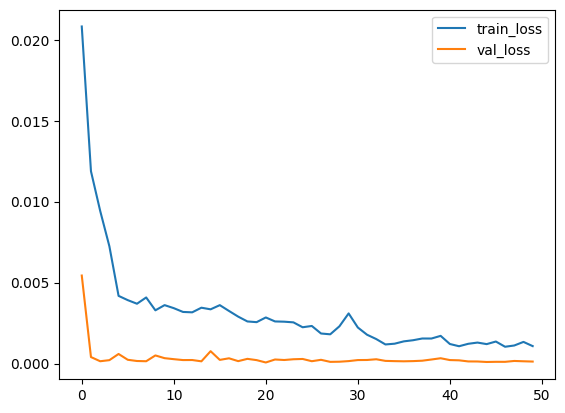

In [29]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

ax = plt.subplot()
line1, = ax.plot(train_loss, label='train_loss')
line2, = ax.plot(val_loss, label='val_loss')
ax.legend(handles=[line1, line2])
plt.show()

In [31]:
final_model = tf.keras.models.load_model('/content/model.keras',
                                   custom_objects={'Time2Vector': Time2Vector,
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/layer_normalization.py:123: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
# Evaluate the final model on the train set
y_pred_train = final_model.predict(X_train)
mse, mae, r2, index_of_agreement, mape = evaluate_model(y_train, y_pred_train)

print('Final Model Evaluation Results (Train Set):')
print_evaluation_results_extended(mse, mae, r2, index_of_agreement, mape)

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 433ms/step
Final Model Evaluation Results (Train Set):
---------------------------
Average MSE: 0.0023710622652323254
Average MAE: 0.026063143965655993
Average R^2: 0.8738868965821773
Mean Index of Agreement: 0.3858966494553311
MAPE: 0.6682014051111733
---------------------------


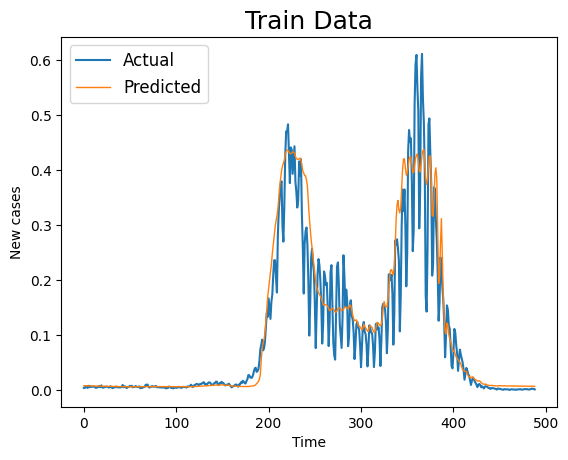

In [33]:
# Create subplots for results
ax = plt.subplot()

# Plot test data results
ax.plot(y_train.flatten(), label='Actual')
ax.plot(y_pred_train.flatten(), linewidth=1, label='Predicted')
ax.set_title("Train Data", fontsize=18)
ax.set_xlabel('Time')
ax.set_ylabel('New cases')
ax.legend(loc="best", fontsize=12)

# Display the plot
plt.show()

In [34]:
# Evaluate the final model on the test set
y_pred = final_model.predict(X_test)
mse, mae, r2, index_of_agreement, mape = evaluate_model(y_test, y_pred)

print('Final Model Evaluation Results:')
print_evaluation_results_extended(mse, mae, r2, index_of_agreement, mape)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Final Model Evaluation Results:
---------------------------
Average MSE: 0.033219743709212525
Average MAE: 0.12761861157112994
Average R^2: 0.2669093806956251
Mean Index of Agreement: 0.33795819474824984
MAPE: 0.33498862083402814
---------------------------


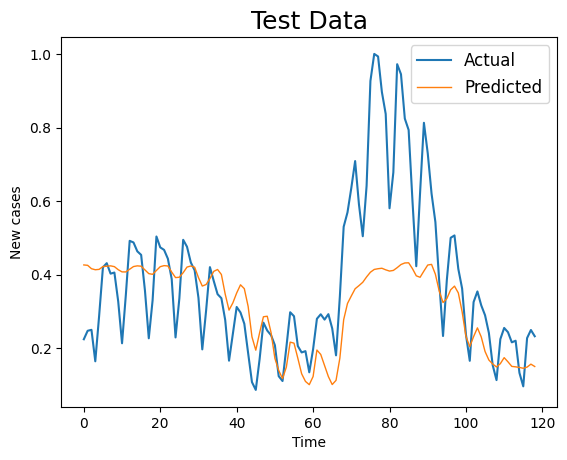

In [35]:
# Create subplots for results
ax = plt.subplot()

# Plot test data results
ax.plot(y_test.flatten(), label='Actual')
ax.plot(y_pred.flatten(), linewidth=1, label='Predicted')
ax.set_title("Test Data", fontsize=18)
ax.set_xlabel('Time')
ax.set_ylabel('New cases')
ax.legend(loc="best", fontsize=12)

# Display the plot
plt.show()